In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
import scipy as sp, numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from scipy import stats

In [3]:
data = pd.read_csv("datarevised.csv", na_values=["?"])
data.columns = ['age','bp','blood glucose random','blood urea','serum creatinine','sodium','potassium','hemoglobin','packed cell volume','white blood cell count','specific gravity', 'albumin', 'sugar','red blood cell count', 'no ckd']

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(data)

newdata = imp_mean.transform(data)

data.shape

(399, 15)

Variance explained:  70.96044452307649 %


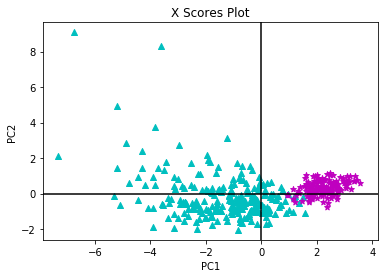

In [4]:
# perform PLSR on data
X = stats.zscore(newdata[:, 0:14])
#Y = stats.zscore(newdata[:, 13])
Y = newdata[:, 14]


p = PLSRegression(n_components = 2)
p.fit(X,Y)
print('Variance explained: ', p.score(X,Y)*100, '%')

xsc = p.x_scores_
ysc = p.y_scores_

plt.scatter(xsc[0:249,0], xsc[0:249,1], color = 'c', marker='^');
plt.scatter(xsc[250:399,0], xsc[250:399,1], color = 'm', marker='*');
plt.title('X Scores Plot');
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.axhline(y=0, color='k');
plt.axvline(x=0, color='k');

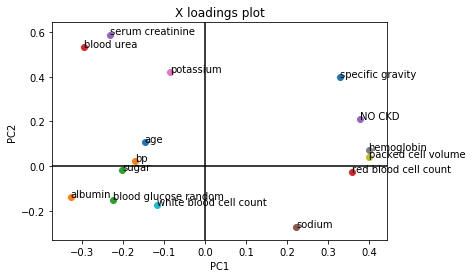

In [5]:
xloads = p.x_loadings_
yloads = p.y_loadings_

for x in range(14):
    plt.scatter(xloads[x,0], xloads[x,1])
#     print(xloads[x,0], xloads[x,1])
#     print(data.columns[x])
    plt.annotate(data.columns[x], (xloads[x,0], xloads[x,1]))

plt.scatter(yloads[:,0], yloads[:,1])
plt.annotate('NO CKD', (yloads[:,0], yloads[:,1]),)

plt.axhline(y=0, color='k');
plt.axvline(x=0, color='k');
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('X loadings plot');

In [6]:
#leave one out cross validation

loo = LeaveOneOut()
Yloo = np.zeros(Y.size)
i = 0

for train, test in loo.split(X):
    newX = X[train,:]
    newY = np.zeros(Y.size - 1)
    k = 0
    for j in train:
        newY[k] = Y[j]
        k = k+1
    p3 = PLSRegression(n_components = 3)
    newX = stats.zscore(newX)
    #newY = stats.zscore(newY)
    p3.fit(newX,newY)
    Yloo[i] = p3.predict(X[test])
    i = i+1

#Yloo = stats.zscore(Yloo)
p3 = PLSRegression(n_components = 3)
p3.fit(X, Yloo)
print('model fitness: ',p3.score(X, Yloo)*100, '%')
Q2Y = ((1 - np.var(Yloo-Y))/np.var(Y))
print(Q2Y)

model fitness:  99.5288257055011 %
3.957956181247328


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

databin = pd.read_csv("databin2.csv", na_values=["?"])
databin.columns = ['red blood cells', 'pus cell', 'pus cell clumps', 'bacteria','hypertension', 'diabetes mellitus', 'coronary artery disease','appetite', 'pedal enema', 'anemia','age','bp','blood glucose random','blood urea','serum creatinine','sodium','potassium','hemoglobin','packed cell volume','white blood cell count','specific gravity', 'albummin', 'sugar','red blood cell count','ckd']
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(databin)
newdatabin = imp_mean.transform(databin)


In [31]:
X = scale(newdatabin[:, 0:24])
y = newdatabin[:, 24]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33)


In [32]:
logreg = LogisticRegression(solver ='liblinear')
logreg.fit(X_train,y_train)

print(logreg.score(X,y))

0.9949874686716792


In [34]:
y_preds = logreg.predict(X_test)

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        82
         1.0       0.96      1.00      0.98        50

   micro avg       0.98      0.98      0.98       132
   macro avg       0.98      0.99      0.98       132
weighted avg       0.99      0.98      0.98       132

[[80  2]
 [ 0 50]]


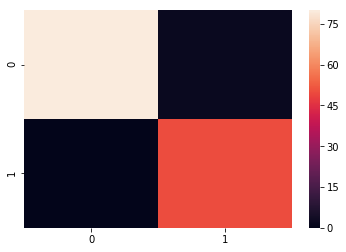

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))
cnf_matrix = metrics.confusion_matrix(y_test, y_preds)
import seaborn as sn
sn.heatmap(cnf_matrix)
print(cnf_matrix)

In [12]:
# match = 0
# no_match = y_test.size
# for k in range(y_test.size):
#     if y_test[k] == y_preds[k]:
#         match = match + 1
#         no_match = no_match - 1

# print(match)
# print(no_match)

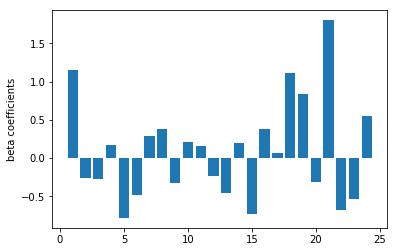

In [22]:
betas = logreg.coef_

# count = 0
# for d in databin.columns[0:24]:
#     print(d, ': ',betas[0,count])
#     count = count + 1

count = 0
betas2 = np.zeros(betas.size)
for b in range(betas.size):
    betas2[count] = betas[0,b]
    count = count + 1

xrange = np.arange(1,25)
plt.bar(xrange, betas2);
plt.ylabel('beta coefficients');

In [37]:
#leave one out cross validation of logreg

loo = LeaveOneOut()
Yloo = np.zeros(y.size)
i = 0

for train, test in loo.split(X):
    newX = X[train,:]
    newY = np.zeros(y.size - 1)
    k = 0
    for j in train:
        newY[k] = y[j]
        k = k+1
    logreg = LogisticRegression(solver='liblinear')
    newX = stats.zscore(newX)
    #newY = stats.zscore(newY)
    logreg.fit(newX,newY)
    Yloo[i] = logreg.predict(X[test])
    i = i+1

#Yloo = stats.zscore(Yloo)
logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(X, Yloo)
print('model fitness: ',logreg.score(X, Yloo)*100, '%')
Q2Y = ((1 - np.var(Yloo-Y))/np.var(Y))
print(Q2Y)

model fitness:  100.0 %
4.230602409638554
